In [1]:
import os
import pandas as pd
import pydicom
import cv2
import numpy as np
import csv
import random

In [2]:
tampered_data_path = r"/mnt/c/Users/jones/OneDrive/Desktop/VS_Code/STA221/Data/tampered_slices"
untampered_data_path = r"/mnt/c/Users/jones/OneDrive/Desktop/VS_Code/STA221/Data/manifest-1600709154662/LIDC-IDRI-Sampled2"

# Getting Slices For Tampered Data

In [3]:
image_size = (256, 256)

# Helper function to process and normalize the image
def process_image(dcm_file):
    pixel_array = dcm_file.pixel_array
    pixel_array = cv2.resize(pixel_array, image_size)
    pixel_array = cv2.normalize(pixel_array, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    return pixel_array

In [4]:
def load_slices(tampered_data_path):
    slices = []
    paths = os.listdir(tampered_data_path)

    for path in paths:
        if path.endswith(".dcm"):
            dcm_path = os.path.join(tampered_data_path, path)
            dcm = pydicom.dcmread(dcm_path)
            pixel_array = process_image(dcm)
            slices.append(pixel_array)
    return np.asarray(slices)

In [5]:
tampered_slices = load_slices(tampered_data_path)
tampered_slices.shape

(1140, 256, 256)

In [6]:
untampered_slices = load_slices(untampered_data_path)
untampered_slices.shape

(1018, 256, 256)

In [7]:
from sklearn.model_selection import train_test_split

# Provided code
untampered_labels = np.zeros(len(untampered_slices))  # 0 = 'untampered'
tampered_labels = np.ones(len(tampered_slices))     # 1 = 'tampered'

print(tampered_slices.shape)
print(untampered_slices.shape)

X_all = np.vstack((untampered_slices, tampered_slices))
y_all = np.hstack((untampered_labels, tampered_labels))

X_all = X_all.reshape(X_all.shape[0], -1)  # Flatten each image to a 1D vector

print(X_all.shape)
print(y_all.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print(np.min(X_test), np.max(X_test))

# Print the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


(1140, 256, 256)
(1018, 256, 256)
(2158, 65536)
(2158,)
0 65535
X_train shape: (1726, 65536)
X_test shape: (432, 65536)
y_train shape: (1726,)
y_test shape: (432,)


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    # Get predictions from the model
    y_pred = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    # Customize the plot
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test):
    # Get predicted probabilities (for the positive class)
    y_prob = model.predict_proba(X_test)[:, 1]  # for binary classification, [1] for positive class

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Compute AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Random classifier line
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import copy

def train_model_with_cross_validation(model, X_train, y_train, n_splits=5):
    # Initialize cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Metrics storage
    metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    best_model = None
    best_accuracy = 0

    # Perform cross-validation
    for train_index, test_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Train the model
        model.fit(X_fold_train, y_fold_train)

        # Predict on the test set
        y_pred = model.predict(X_fold_test)

        # Compute metrics
        metrics["accuracy"].append(accuracy_score(y_fold_test, y_pred))
        metrics["precision"].append(precision_score(y_fold_test, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_fold_test, y_pred, zero_division=0))
        metrics["f1_score"].append(f1_score(y_fold_test, y_pred, zero_division=0))

        print("Fold accuracy:", metrics["accuracy"][-1])

        if metrics["accuracy"][-1] > best_accuracy:
            best_accuracy = metrics["accuracy"][-1]
            best_model = copy.deepcopy(model)

    # Compute average metrics
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}

    return avg_metrics, best_model

# Logistic Regression

Fold accuracy: 0.8554913294797688
Fold accuracy: 0.9014492753623189
Fold accuracy: 0.9014492753623189
Fold accuracy: 0.8579710144927536
Fold accuracy: 0.9130434782608695
{'accuracy': np.float64(0.8858808745916059), 'precision': np.float64(0.8909349776326003), 'recall': np.float64(0.8935567165075362), 'f1_score': np.float64(0.89215223904231)}
Test Accuracy: 0.8981


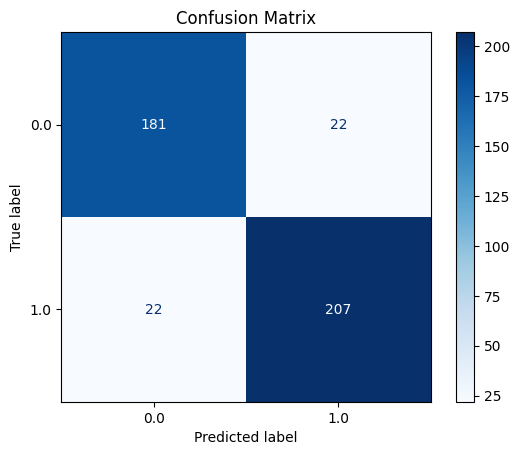

AUC: 0.9379


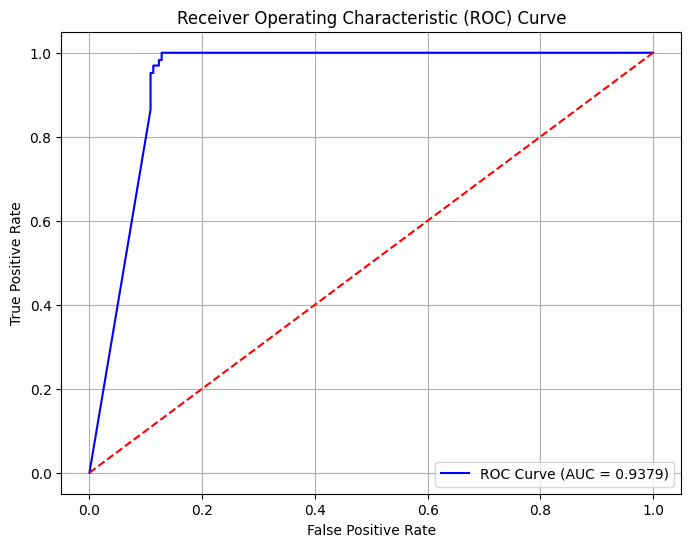

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# Random Forest

Fold accuracy: 0.8063583815028902
Fold accuracy: 0.8521739130434782
Fold accuracy: 0.8376811594202899
Fold accuracy: 0.8057971014492754
Fold accuracy: 0.8521739130434782
{'accuracy': np.float64(0.8308368936918823), 'precision': np.float64(0.8384367344099232), 'recall': np.float64(0.8430312856542365), 'f1_score': np.float64(0.8405255273516777)}
Test Accuracy: 0.8148


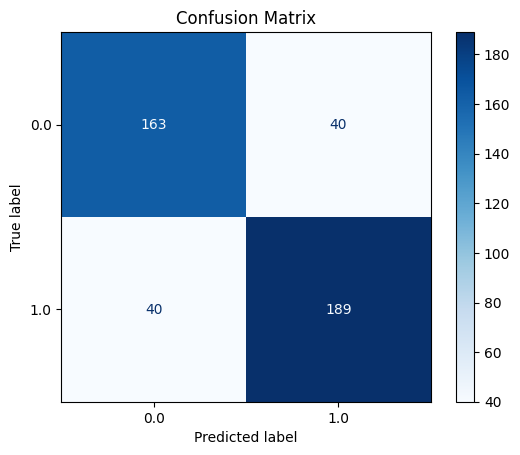

AUC: 0.9082


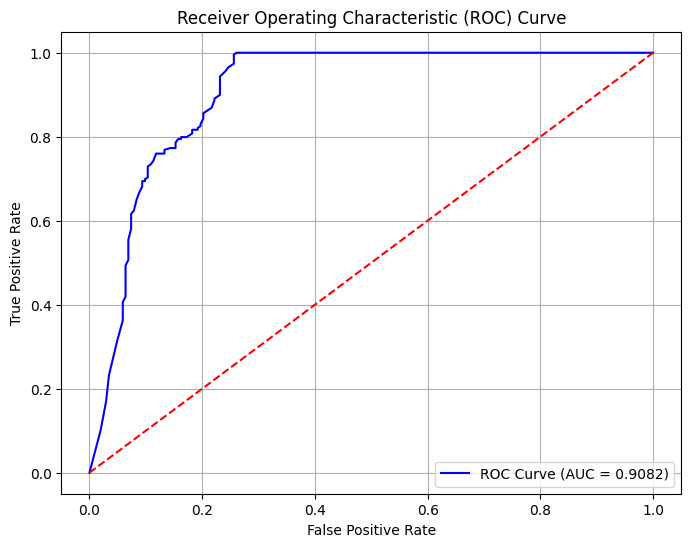

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# Decision Tree

Fold accuracy: 0.8179190751445087
Fold accuracy: 0.8434782608695652
Fold accuracy: 0.8173913043478261
Fold accuracy: 0.8028985507246377
Fold accuracy: 0.8318840579710145
{'accuracy': np.float64(0.8227142498115105), 'precision': np.float64(0.8507402873859424), 'recall': np.float64(0.8056986729117875), 'f1_score': np.float64(0.8275434103009764)}
Test Accuracy: 0.7986


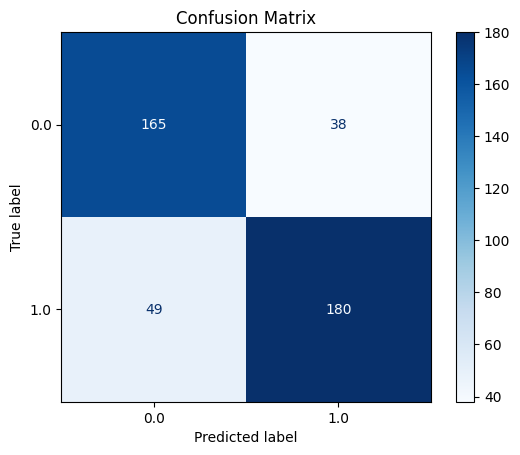

AUC: 0.7994


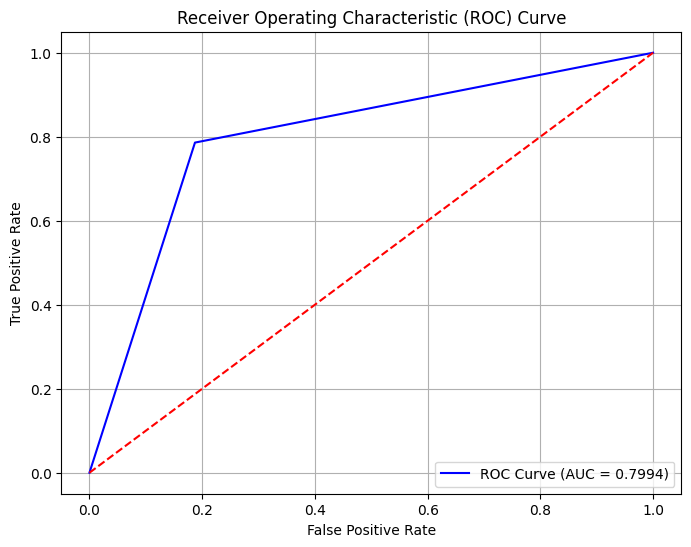

In [27]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# SVM

Fold accuracy: 0.8670520231213873
Fold accuracy: 0.9217391304347826
Fold accuracy: 0.9014492753623189
Fold accuracy: 0.8695652173913043
Fold accuracy: 0.9101449275362319
{'accuracy': np.float64(0.893990114769205), 'precision': np.float64(0.8437232175110119), 'recall': np.float64(0.9824536119618088), 'f1_score': np.float64(0.9075555408671484)}
Test Accuracy: 0.8912


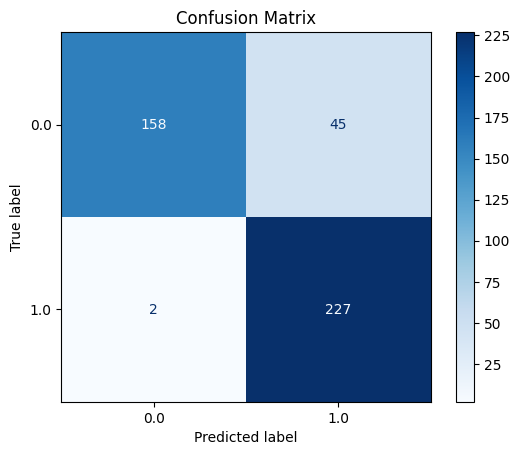

AUC: 0.9388


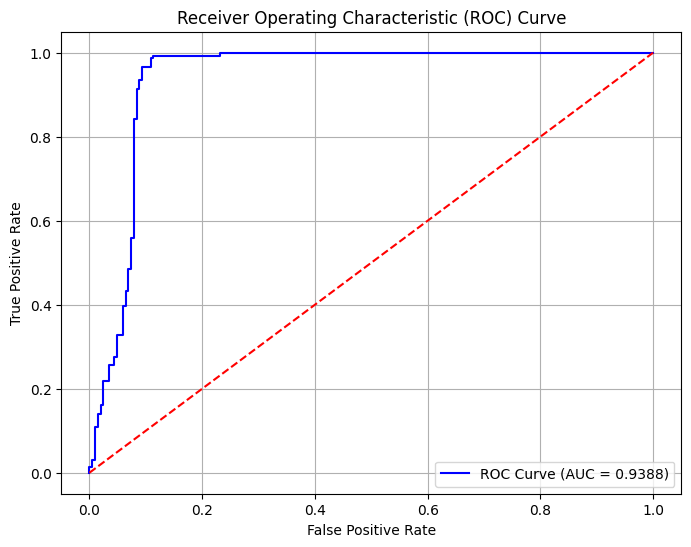

In [28]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1, probability=True)

results, best_model = train_model_with_cross_validation(model, X_train, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test, y_test)
plot_roc_curve(best_model, X_test, y_test)

# PCA

X_train shape (PCA): (1726, 109)
X_test shape (PCA): (432, 109)
y_train shape: (1726,)
y_test shape: (432,)


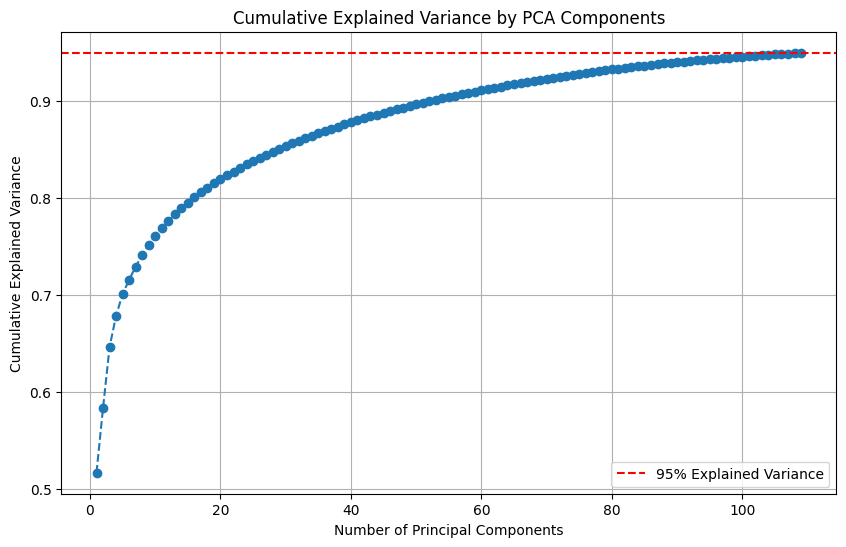

In [11]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the shapes of the splits after PCA
print(f"X_train shape (PCA): {X_train_pca.shape}")
print(f"X_test shape (PCA): {X_test_pca.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.show()

# Logistic Regression

Fold accuracy: 0.9104046242774566
Fold accuracy: 0.9420289855072463
Fold accuracy: 0.9101449275362319
Fold accuracy: 0.9072463768115943
Fold accuracy: 0.9333333333333333
{'accuracy': np.float64(0.9206316494931726), 'precision': np.float64(0.8835290328332925), 'recall': np.float64(0.9791388938929921), 'f1_score': np.float64(0.9287862198212509)}
Test Accuracy: 0.9329


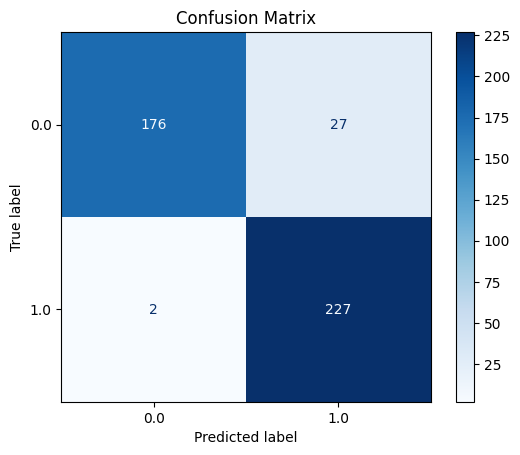

AUC: 0.9203


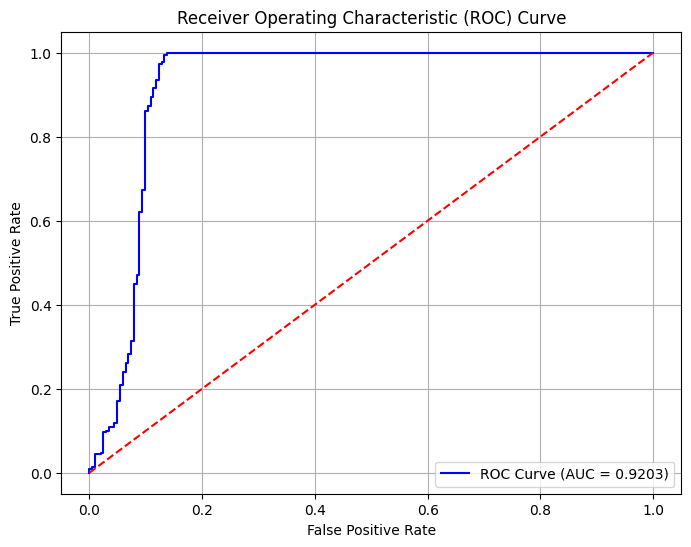

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# Random Forest

Fold accuracy: 0.9393063583815029
Fold accuracy: 0.9449275362318841
Fold accuracy: 0.9594202898550724
Fold accuracy: 0.9333333333333333
Fold accuracy: 0.9623188405797102
{'accuracy': np.float64(0.9478612716763006), 'precision': np.float64(0.9263594806939952), 'recall': np.float64(0.97914489881703), 'f1_score': np.float64(0.9519916336429881)}
Test Accuracy: 0.9537


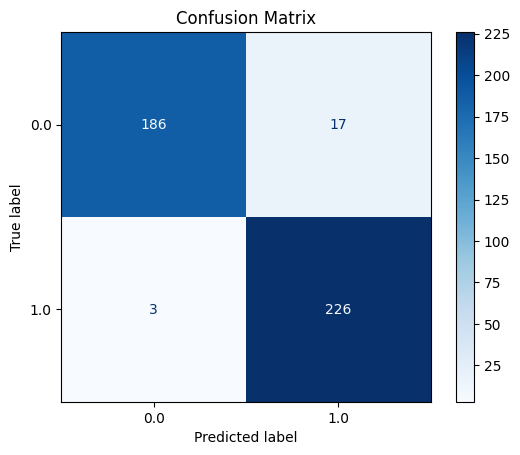

AUC: 0.9329


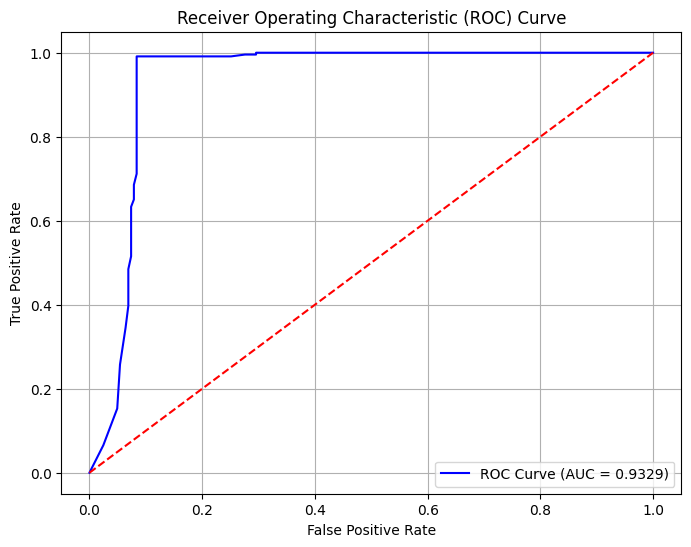

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# Decision Tree

Fold accuracy: 0.884393063583815
Fold accuracy: 0.8956521739130435
Fold accuracy: 0.8927536231884058
Fold accuracy: 0.8666666666666667
Fold accuracy: 0.8927536231884058
{'accuracy': np.float64(0.8864438301080673), 'precision': np.float64(0.9041877976308564), 'recall': np.float64(0.8781480814267699), 'f1_score': np.float64(0.8909225197984568)}
Test Accuracy: 0.8796


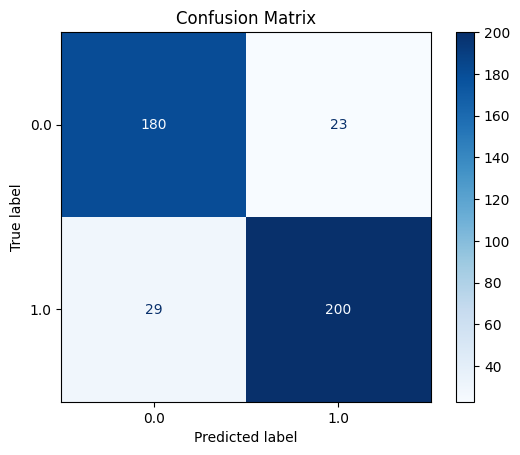

AUC: 0.8800


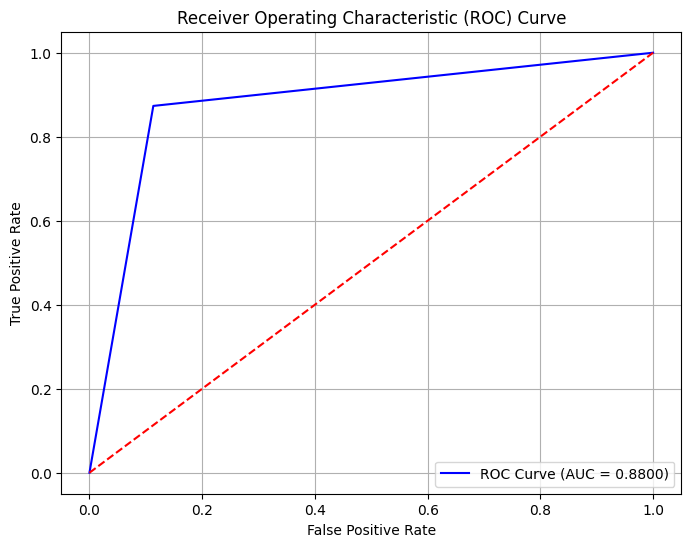

In [14]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# SVM

Fold accuracy: 0.9046242774566474
Fold accuracy: 0.9391304347826087
Fold accuracy: 0.927536231884058
Fold accuracy: 0.9072463768115943
Fold accuracy: 0.9333333333333333
{'accuracy': np.float64(0.9223741308536484), 'precision': np.float64(0.8772669500891107), 'recall': np.float64(0.99231369723173), 'f1_score': np.float64(0.9311368111048669)}
Test Accuracy: 0.9190


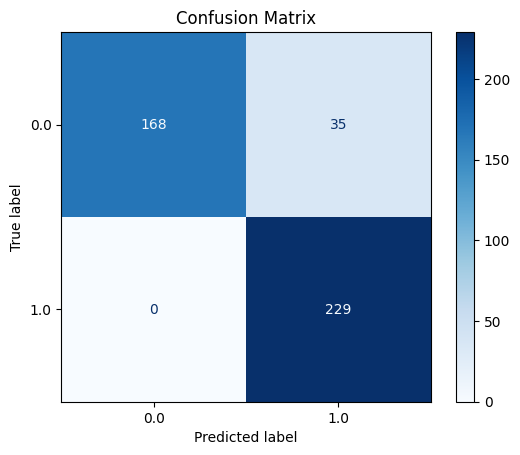

AUC: 0.9375


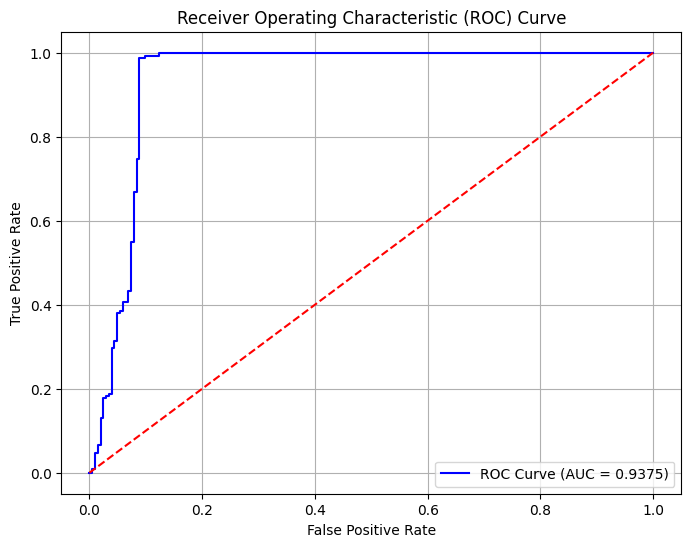

In [15]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1, probability=True)

results, best_model = train_model_with_cross_validation(model, X_train_pca, y_train, n_splits=5)
print(results)

plot_confusion_matrix(best_model, X_test_pca, y_test)
plot_roc_curve(best_model, X_test_pca, y_test)

# Neural Networks

In [11]:
import cv2
import numpy as np

# Resize function for a batch of images
def resize_images(images, target_size=(224, 224)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    return resized_images

# Resize your datasets
untampered_data_resized = resize_images(untampered_slices, target_size=(224, 224))
tampered_slices_resized = resize_images(tampered_slices, target_size=(224, 224))


In [12]:
# Convert grayscale to RGB
def ensure_rgb(images):
    return np.stack([images] * 3, axis=-1) if images.ndim == 3 else images

untampered_data_resized = ensure_rgb(untampered_data_resized)
tampered_slices_resized = ensure_rgb(tampered_slices_resized)


In [13]:
import numpy as np

# Combine data
all_data = np.concatenate((untampered_data_resized, tampered_slices_resized), axis=0)
all_labels = np.concatenate((untampered_labels, tampered_labels), axis=0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

print(np.min(X_test), np.max(X_test))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


0 65535
(1726, 224, 224, 3)
(432, 224, 224, 3)
(1726,)
(432,)


In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',           # Path to save the best model
    monitor='val_accuracy',             # Metric to monitor
    save_best_only=True,                # Save only the model with the best validation accuracy
    save_weights_only=False,            # Save the entire model (set to True for weights only)
    mode='max',                         # Maximize the monitored metric
    verbose=1                           # Print message when saving the model
)

X_train_neural = preprocess_input(X_train)  # Preprocess for VGG16
X_test_neural = preprocess_input(X_test)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_neural, y_train, validation_data=(X_test_neural, y_test), epochs=50, batch_size=32, callbacks=[checkpoint_callback])


2024-12-10 12:05:28.989841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 12:05:29.115290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733861129.173288  112546 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733861129.189735  112546 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 12:05:29.288921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/50


I0000 00:00:1733861139.993392  112732 service.cc:148] XLA service 0x7f386c0020d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733861139.993455  112732 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-10 12:05:40.179481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733861141.131299  112732 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/54 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5677 - loss: 6697.4653

I0000 00:00:1733861143.226237  112732 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6659 - loss: 3226.4248
Epoch 1: val_accuracy improved from -inf to 0.87037, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.6672 - loss: 3192.0891 - val_accuracy: 0.8704 - val_loss: 41.7817
Epoch 2/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7794 - loss: 82.1351
Epoch 2: val_accuracy improved from 0.87037 to 0.87731, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7793 - loss: 83.1751 - val_accuracy: 0.8773 - val_loss: 66.7765
Epoch 3/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8163 - loss: 85.4937
Epoch 3: val_accuracy improved from 0.87731 to 0.88889, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8153 - loss: 86.4900 - val_accuracy: 0.8889 - val_loss: 47.6295
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8520 - loss: 54.8555
Epoch 4: val_accuracy did not improve from 

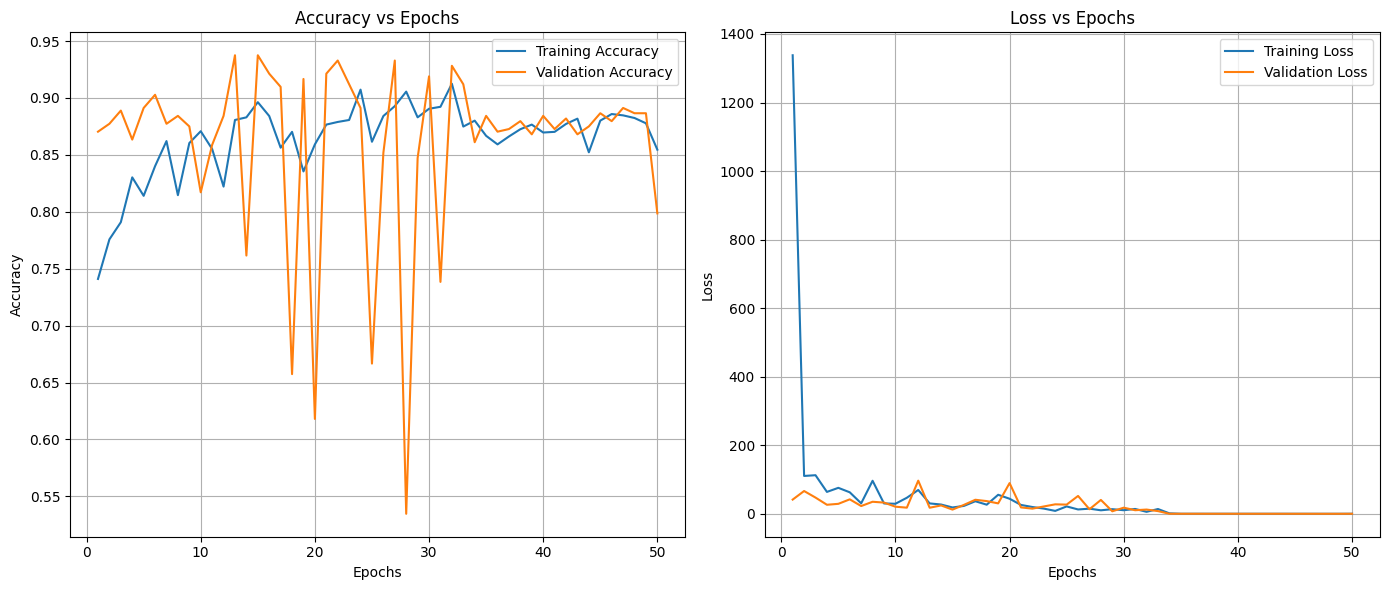

In [15]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract epoch range
epochs = range(1, len(train_accuracy) + 1)

# Create subplots for accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step


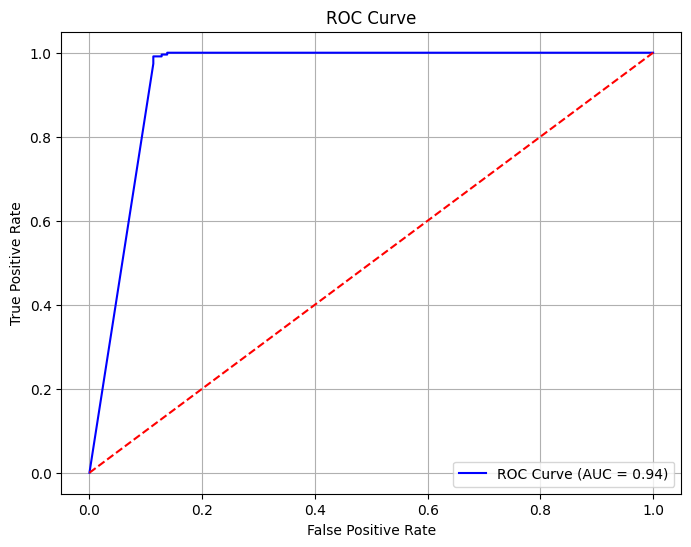

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_neural)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0 255


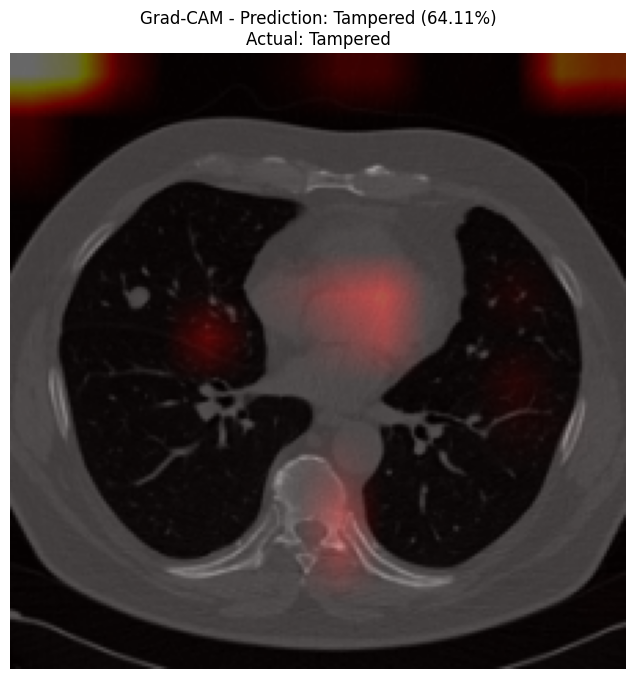

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0 255


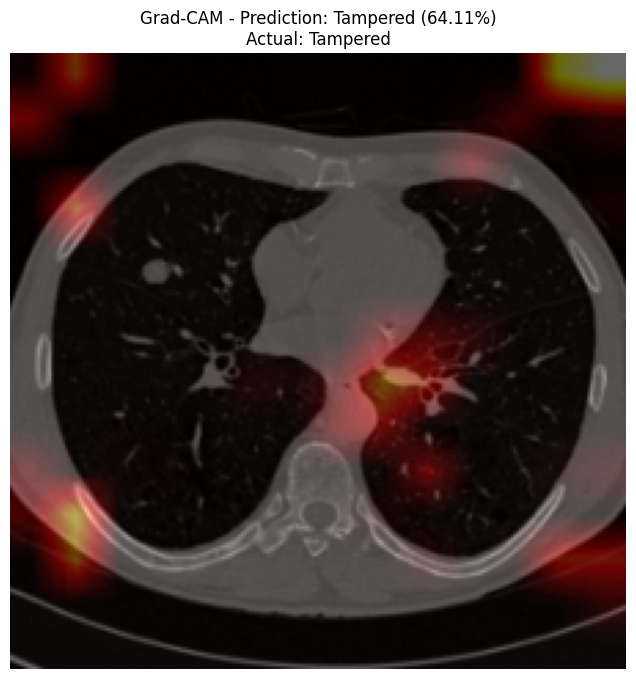

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0 255


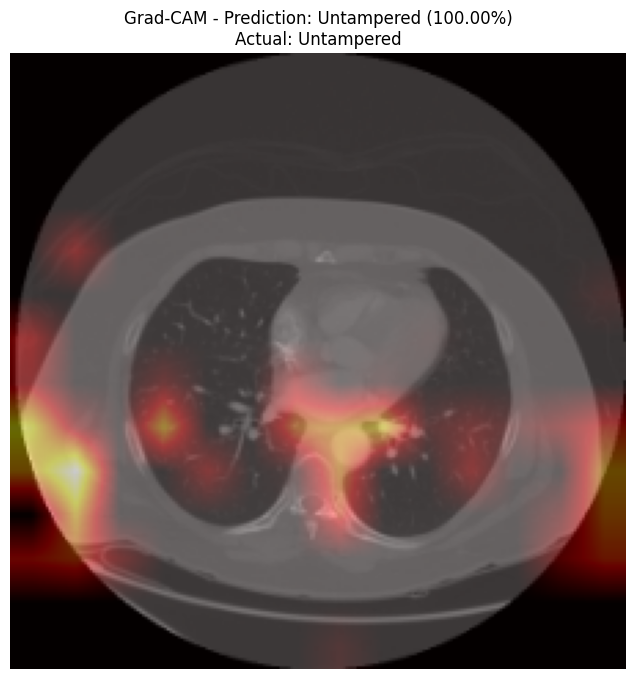

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0 255


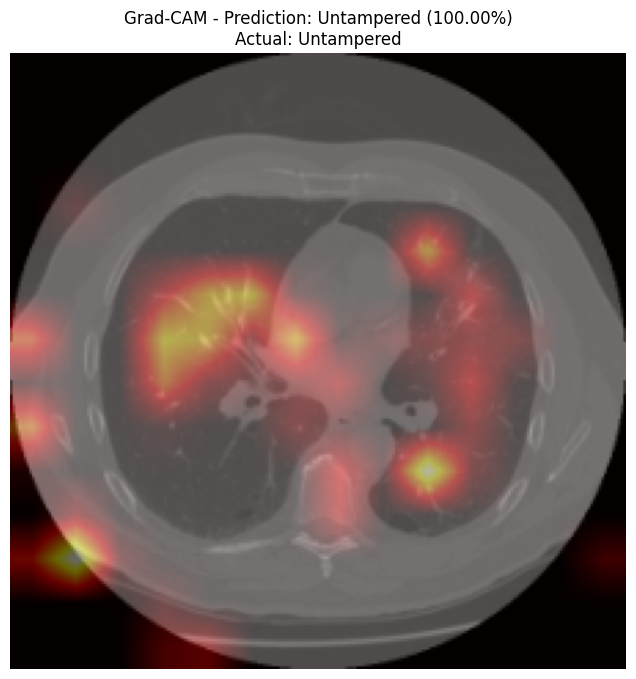

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0 255


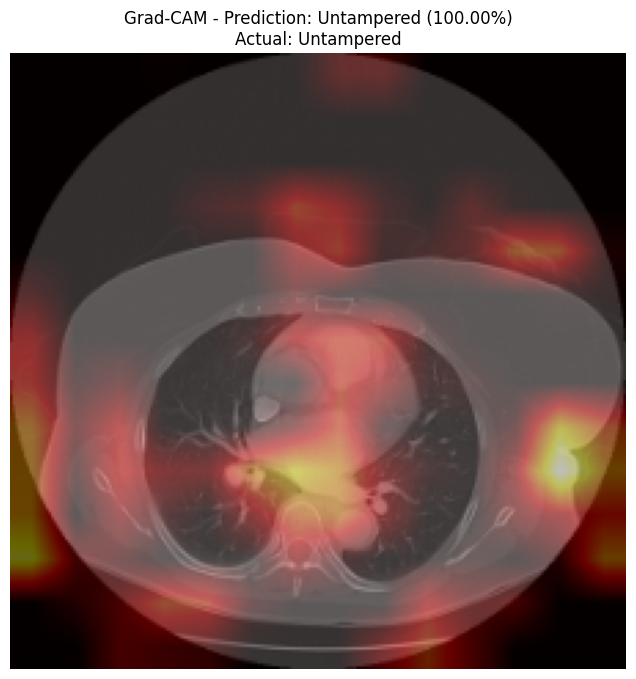

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0 255


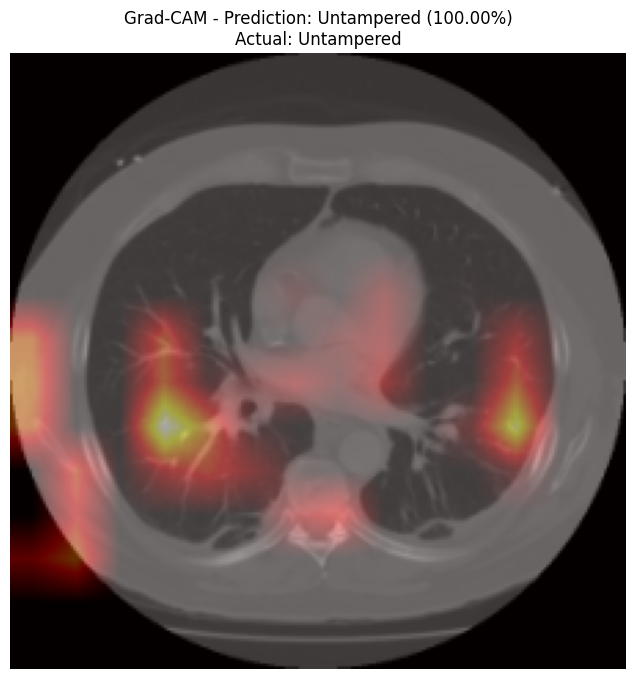

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0 255


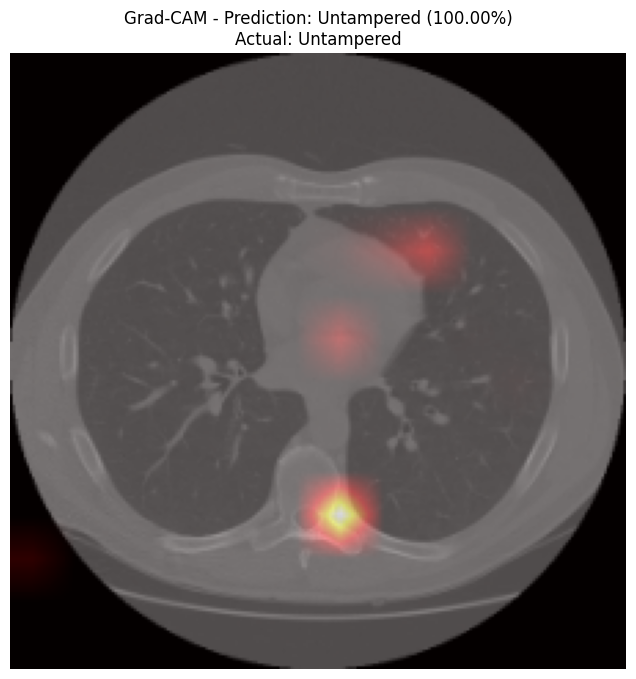

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0 255


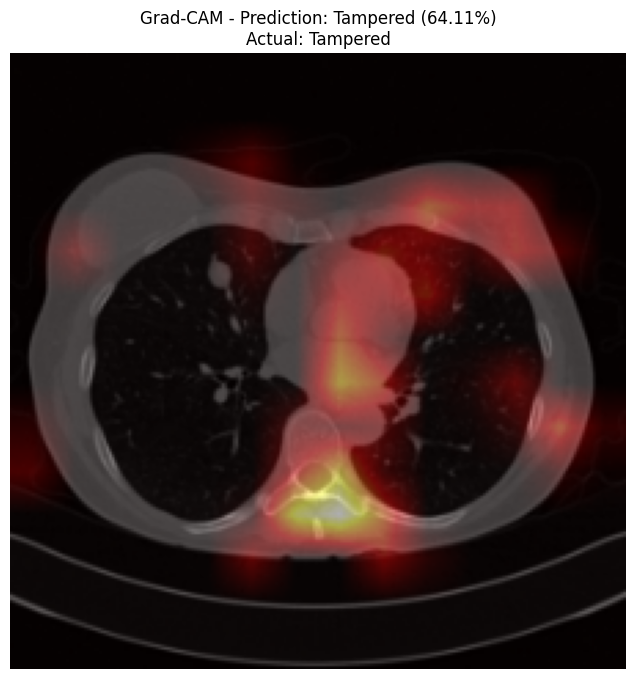

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0 255


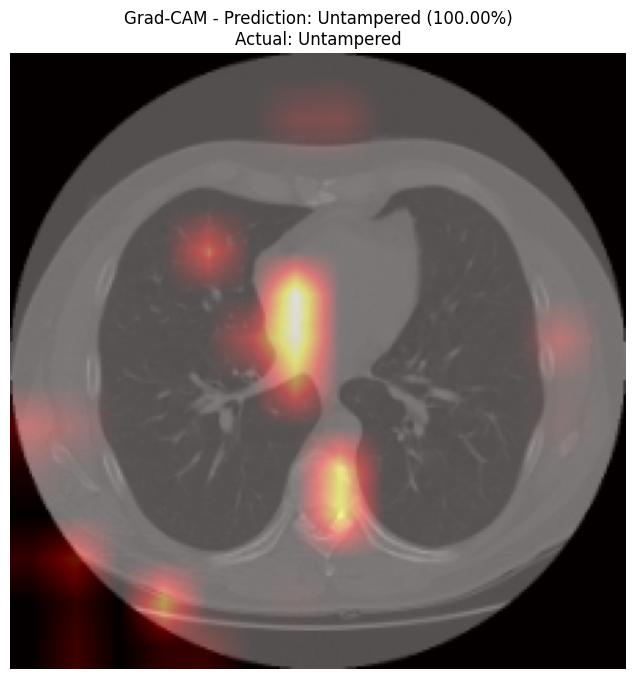

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0 255


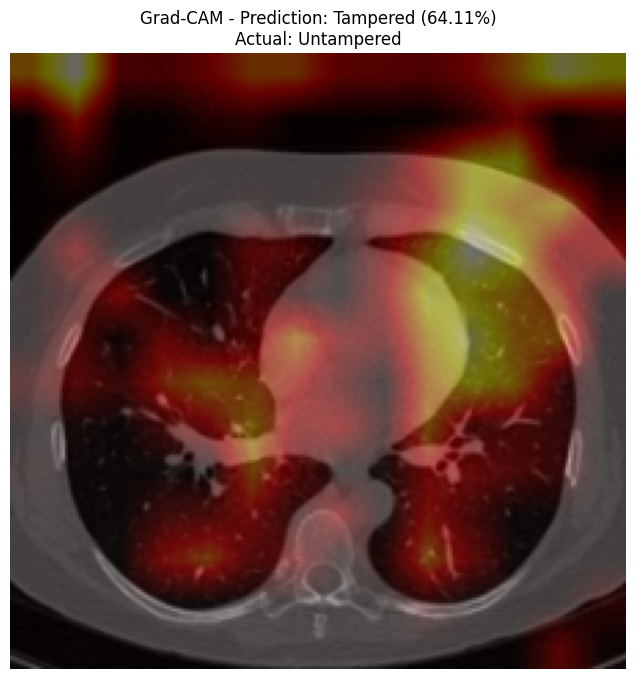

In [21]:
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the target class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature map by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to focus on positive values
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


model = load_model('best_model.keras')
for index in range(10):
    # Choose an image from the test set
    img_index = random.randint(0, len(X_test_neural) - 1)  # Index of the test image
    img = X_test_neural[img_index]
    img_array = np.expand_dims(img, axis=0)

    prediction = model.predict(img_array)
    predicted_class = "Tampered" if prediction[0] >= 0.5 else "Untampered"
    confidence = prediction[0][0] * 100 if prediction[0] >= 0.5 else (1 - prediction[0][0]) * 100

    actual_class = "Tampered" if y_test[img_index] == 1 else "Untampered"


    img -= np.min(img)
    if np.max(img) != 0:
        img /= np.max(img)
    img *= 255
    img = img.astype(np.uint8)

    img_array = np.expand_dims(img, axis=0)

    # Compute Grad-CAM heatmap
    last_conv_layer_name = "conv4_block3_3_conv"  # Replace with your last convolutional layer's name
    heatmap = compute_gradcam(model, img_array, last_conv_layer_name)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Convert heatmap to a format suitable for visualization
    heatmap = np.uint8(255 * heatmap)
    

    # Overlay the heatmap on the original image
    print(np.min(img), np.max(img))
    original_image = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV if needed
    heatmap_color = plt.cm.hot(heatmap)  # Convert the heatmap to a color image with 'HOT' colormap
    heatmap_color = (heatmap_color[:, :, :3] * 255).astype(np.uint8)  # Remove alpha channel and scale to [0, 255]

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Display the image with Grad-CAM heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM - Prediction: {predicted_class} ({confidence:.2f}%)\nActual: {actual_class}')
    plt.axis('off')
    plt.show()
